## Imports

In [34]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ipyparallel as ipp
import matplotlib.pyplot as plt
import folium 
import requests
import json
import time
import dill
import os
import pyomo.environ as pyo
from pyomo.environ import *

## Utils

### Adjacency matrix class

In [2]:
## Class to create an adjacency matrix from a list of coordinates

class AdjacencyMatrix:
    
    # ------------------------------------ define the constructor ------------------------------------
    def __init__(self, coordinates: gpd.geoseries.GeoSeries, kind="geometric", epsg=32610, mode="distance"):
        self.coordinates = coordinates
        self.mode = mode
        self.kind = kind
        self.epsg = epsg
        self.adjacency_matrix = self.create_adjacency_matrix()
    
    # ------------------------- define the method to create the adjacency matrix ---------------------
    def __geometric_distance(self, n):
        distances = np.zeros((n, n))
        rows, cols = np.indices(distances.shape)

        for i in range(n):
            diag_row_sup = np.diag(rows, k=i)
            diag_col_sup = np.diag(cols, k=i)
            
            diag_row_inf = np.diag(rows, k=-i)
            diag_col_inf = np.diag(cols, k=-i)
            
            d = self.coordinates.distance(self.coordinates.shift(-i).to_crs(epsg=self.epsg)).dropna().values
            
            distances[diag_row_sup, diag_col_sup] = d
            distances[diag_row_inf, diag_col_inf] = d
        return distances
        
    def create_adjacency_matrix(self):
        
        n = len(self.coordinates)
        
        if self.kind == "geometric":
            self.coordinates = self.coordinates.to_crs(epsg=self.epsg)
            distances = self.__geometric_distance(n)
        
        elif self.kind == "osrm":
            distances = np.zeros((n,n))
            
            if n > 100:
                chunks = n//100
            else:
                chunks = 1
                
            if type(self.coordinates) == gpd.geoseries.GeoSeries:
                coordinates_list = [[point.xy[0][0], point.xy[1][0]] for point in self.coordinates]
            
            fix_url = "http://router.project-osrm.org/table/v1/driving/"
            coordinates_url = "".join(["".join(str(str([i[0],i[1]]))[1:-1].split())+";" for i in coordinates_list])[:-1]
                    
            # split the coordinates in chunks of 100
            for i in range(chunks):
                if i < chunks-1:
                    source_indexes = list(range(0+100*i,100+100*i))
                else:
                    source_indexes = list(range(0+100*i,n))
                
                # define the sources URL
                sources_url = "sources="+";".join(str(k) for k in source_indexes)
                
                for j in range(chunks):
                    if j < chunks-1:
                        destination_indexes = list(range(0+100*j,100+100*j))
                    else:
                        destination_indexes = list(range(0+100*j,n))
                    
                    # define the destinations URL
                    destinations_url = "destinations="+";".join(str(k) for k in destination_indexes)

                    # call the OSMR API
                    r = requests.get(fix_url+coordinates_url+f"?annotations={self.mode}&"+sources_url+"&"+destinations_url)
                    routes = json.loads(r.content)
                            
                    distances[0+100*i:100+100*i, 0+100*j:100+100*j] = np.array(routes[self.mode+'s'])
        
        return distances

In [2]:
# def distance_matrix_by_car(coordinates, mode="all-vs-all", n=0, m=0):
        
#     # define the first part of the URL (common for all modes)
#     fix_url = "http://router.project-osrm.org/table/v1/car/"
#     coordinates_url = "".join(["".join(str(str([i[0],i[1]]))[1:-1].split())+";" for i in coordinates])[:-1]
    
#     # define the number of coordinates
#     n = len(coordinates)
    
#     # if the number of coordinates is less than 100, the API can be called directly
#     if n <= 100:
        
#         # if mode is "all-vs-all" all the coordinates are used as sources and destinations
#         if mode == "all-vs-all": 
#             r = requests.get(fix_url+coordinates_url+"?annotations=distance")
            
#         # if mode is "n-vs-all" the first n coordinates are used as sources and all the coordinates are used as destinations
#         elif mode == "n-vs-all":
#             r = requests.get(fix_url+coordinates_url+"?annotations=distance&sources="+';'.join(str(i) for i in list(range(n+1))))
            
#         # if mode is "n-vs-m" the first n coordinates are used as sources and the last m coordinates are used as destinations
#         elif mode == "n-vs-m":
#             r = requests.get(fix_url+coordinates_url+"?annotations=distance&sources="+';'.join(str(i) for i in list(range(n+1)))+"&destinations="+';'.join(str(len(coordinates)-i-1) for i in list(range(m+1))))
        
#         # load the response using the json libray
#         routes = json.loads(r.content)
#         distances = np.array(routes["distances"])
    
#     # if the number of coordinates is greater than 100, the API can be called only with chunks of 100 coordinates
#     else:
#         if mode == "all-vs-all": 
#             distances = np.zeros((n,n))
#             chunks = n//100
            
#             # split the coordinates in chunks of 100
#             for i in range(chunks):
#                 if i < chunks-1:
#                     source_indexes = list(range(0+100*i,100+100*i))
#                 else:
#                     source_indexes = list(range(0+100*i,n))
                
#                 # define the sources URL
#                 sources_url = "sources="+";".join(str(k) for k in source_indexes)
                
                
#                 for j in range(chunks):
#                     if j < chunks-1:
#                         destination_indexes = list(range(0+100*j,100+100*j))
#                     else:
#                         destination_indexes = list(range(0+100*j,n))
                    
#                     # define the destinations URL
#                     destinations_url = "destinations="+";".join(str(k) for k in destination_indexes)

#                     # call the OSMR API
#                     r = requests.get(fix_url+coordinates_url+"?annotations=distance&"+sources_url+"&"+destinations_url)
#                     routes = json.loads(r.content)
                    
#                     distances[0+100*i:100+100*i, 0+100*j:100+100*j] = np.array(routes["distances"])
            
#         else:
#             print("the only mode available for more than 100 coordinates is 'all-vs-all'")
    
#     return distances

### FacilityLocation class

In [41]:
class FacilityLocation:
    
    # ----------------------------------------------- define the constructor -----------------------------------------------
    
    locations_coordinates = None
    locations_index = None
    solution_value = None
    algorithm = None
    solver_status = None
    instance = None
    result = None
    computation_time = None
    
    def __init__(self, coordinates: gpd.geoseries.GeoSeries, n_of_locations_to_choose: int, adjancency_matrix: AdjacencyMatrix):
        self.coordinates = coordinates
        self.n_of_locations_to_choose = n_of_locations_to_choose
        self.adjacency_matrix = adjancency_matrix.adjacency_matrix
        self.adjacency_matrix_weight = self.__get_weight(adjancency_matrix)
        self.n_of_demand_points = len(coordinates)
    
    
    # --------------------------- define the private method to retrieve the type of input matrix ---------------------------
    def __get_weight(self, adjancency_matrix):
        if adjancency_matrix.kind == "geometric":
            return " ".join([adjancency_matrix.kind, "distance"])
        else:
            return " ".join([adjancency_matrix.kind, adjancency_matrix.mode])
    
    # --------------------------------------------- implement the GON algorithm --------------------------------------------
    def __max_dist_point(self, C):
    
        min_point_dist = self.adjacency_matrix[C, :].min(axis=0)
        max_index = min_point_dist.argmax()
                
        return max_index

    # a single iteration of the GON algorithm
    def __global_iteration(self, C):
        for i in range(self.n_of_locations_to_choose-1):
            # find the point that is the farthest from the set C
            # print time for each iteration to see the progress of the algorithm 
            max_index = self.__max_dist_point(C)
            C.append(max_index)
            
        max_index = self.__max_dist_point(C)
        
        return self.adjacency_matrix[C, max_index].min()
    
    # main function
    def __solve_gon(self):
        np.random.seed(1783297)
        
        C = []
            
        # choose a random point from V as the first centroid
        init = np.random.randint(0, self.n_of_demand_points)
        C.append(init)
            
        self.solution_value = self.__global_iteration(C)

        self.locations_index = C
        self.locations_coordinates = [self.coordinates[i] for i in self.locations_index]

    def __solve_gon_plus(self, n_trial):
        if n_trial > 1  and n_trial <= self.n_of_demand_points :
            C_l = []
            d = []
            
            # choose n_trial random points from V as the first centroids
            init = np.random.randint(0, len(self.coordinates), n_trial)
             
            for i in range(n_trial):
                C_l.append([])
                C_l[i].append(init[i])

                
                d.append(self.__global_iteration(C_l[i]))
        
            self.solution_value = np.min(d)
            self.locations_index = C_l[np.argmin(d)]
            self.locations_coordinates = [self.coordinates[i] for i in self.locations_index]
            
        else:
            return "n_trial must be greater than 1 and less than the number of coordinates"

    
    # --------------------------------------------- implement the exact algorithm ------------------------------------------
    # define model constraints
    def __completeSingleCoverage(self, model, i):
            return sum(model.y[i, j] for j in model.J) == 1
        
    def __maximumLocations(self, model):
        return sum([model.x[j] for j in model.J])  == pyo.value(model.p)

    def __maximalDistance(self, model, i):
        return sum(model.d[i, j] * model.y[i, j] for j in model.J) <= model.L

        
    def __servedByOpenFacility(self, model, i, j):
        return model.y[i, j] <= model.x[j]
    
    # define the objective function
    def __maximalDistanceObj(self, model):
            return model.L
    
    def __DefineAbstractModel(self):
        #-------------------------abastract model----------------------------
        model = pyo.AbstractModel()

        #---------------------------index sets-------------------------------
        model.I = pyo.RangeSet(0, len(self.coordinates)-1)
        model.J = pyo.RangeSet(0, len(self.coordinates)-1)

        #---------------------------parameters-------------------------------
        # define the number of locations to be opened (p)
        model.p = pyo.Param(within = PositiveIntegers)

        # define the distance matrix (d)
        model.d = pyo.Param(model.I, model.J, within = NonNegativeReals)

        #---------------------------variables--------------------------------
        # define the binary variables for the location decision (x)
        model.x = Var(model.J, within = Binary)

        # define the binary variables for the assignment decision (y)
        model.y = Var(model.I, model.J, within = Binary)

        # define the auxiliary variable for the maximal distance (L)
        model.L = Var(within = NonNegativeReals)

        #--------------------------constraints-------------------------------
        # define a constraint for each demand point to be covered by a single location
        model.completeSingleCoverage = Constraint(model.I, rule = self.__completeSingleCoverage)
        
        # define a constraint for the maximum number of locations 
        model.maximumLocations = Constraint(rule = self.__maximumLocations)
        
        
        # define a constraint for the maximal distance (L is an auxiliary variable)
        model.maximalDistance = Constraint(model.I, rule = self.__maximalDistance)
        
       # define a constraint for each demand point to be served by an open facility
        model.servedByOpenFacility = Constraint(model.I, model.J, rule = self.__servedByOpenFacility)

        #-----------------------objective function---------------------------
        model.maximalDistanceObj = Objective(rule = self.__maximalDistanceObj, sense = minimize)
        
        return model
    
    def __solve_exact(self):
        model = self.__DefineAbstractModel()
        distance_data = {(i, j): self.adjacency_matrix[i][j] for i in range(self.n_of_demand_points) for j in range(self.n_of_demand_points)}
        data = {None: {'p': {None: self.n_of_locations_to_choose}, 
                       'd': distance_data}}
        self.instance = model.create_instance(data)
        opt = SolverFactory('cplex')

        self.result = opt.solve(self.instance)
        
        self.solution_value = self.instance.L.value
        self.locations_index = [i for i in range(self.n_of_demand_points) if self.instance.x[i].value == 1]
        self.locations_coordinates = [self.coordinates[i] for i in self.locations_index]
        
        # Update the status of the solver
        if self.result.solver.status == pyo.SolverStatus.ok and self.result.solver.termination_condition == pyo.TerminationCondition.optimal:
            self.solver_status = 'Optimal solution found'
        elif self.result.solver.termination_condition == pyo.TerminationCondition.infeasible:
            self.solver_status = 'Problem is infeasible'
        else:
            self.solver_status = self.result.solver.termination_condition
        
        
    # ---------------------------------------- implement the methods to solve the problem -----------------------------------
    def solve(self, mode = "exact", algorithm = "gon", n_trial = None):
        t1 = time.time()
        
        if mode == "exact":
            self.__solve_exact()
        
        elif mode == "approx":
            if algorithm == "gon":
                self.__solve_gon()
                
            elif algorithm == "gon_plus":
                self.__solve_gon_plus(n_trial)

        else:
            return "mode must be either 'exact' or 'approx'"
        
        t2 = time.time()
        
        self.computation_time = t2-t1
        self.algorithm = mode if mode == "exact" else algorithm
            
    
    # ---------------------------------------- implement the methods to visualize the solution -----------------------------------
    def plot(self):
        if self.locations_coordinates == None:
            return "solve the problem first"
        
        fig, ax = plt.subplots()
        
        ax.scatter([x for x in np.array(self.coordinates)[:,0]], [x for x in np.array(self.coordinates)[:,1]], c = 'blue')
        ax.scatter([x for x in np.array(self.locations_coordinates)[:,0]], [x for x in np.array(self.locations_coordinates)[:,1]], c = 'red')
        
        return fig, ax
    
    # ---------------------------------------- implement the methods to save and load the solution -----------------------------------
    # save the solution
    def save(self, file_name):
        if self.locations_coordinates == None:
            return "solve the problem first"
        
        with open(file_name, 'wb') as f:
            dill.dump(self, f)
    
    # load the solution
    def load(file_name):
        with open(file_name, 'rb') as f:
            self = dill.load(f)
            
        return self

### FacilityLocationReport class

In [60]:
class FacilityLocationReport:
    
    # ---------------------------------------------------------------- define the constructor ---------------------------------------------------------------
    def __init__(self, facility_locations: list[FacilityLocation]):
        self.facility_locations = facility_locations
        
        
    # ---------------------------------------------------------------- define the methods -------------------------------------------------------------------
    # function to jitter the data to avoid overlapping of the points
    def __rand_jitter(self, list):
        stdev = 0.01 * (max(list) - min(list))
        return list + np.random.randn(len(list)) * stdev
    
    # get the number of different algorithms
    def __adjacency_matrix_weight_from_list_to_dict(self):
        d = {}
        n = len(self.facility_locations)
        
        for i in range(n):
            if self.facility_locations[i].adjacency_matrix_weight not in d.keys():
                d[self.facility_locations[i].adjacency_matrix_weight] = [i]
            else:
                d[self.facility_locations[i].adjacency_matrix_weight].append(i)
        return d
    
    def __algorithm_from_list_to_dict(self):
        d = {}
        n = len(self.facility_locations)
        
        for i in range(n):
            if self.facility_locations[i].algorithm not in d.keys():
                d[self.facility_locations[i].algorithm] = [i]
            else:
                d[self.facility_locations[i].algorithm].append(i)
        return d
    
    # plot scatter plots of the facility location solutions, one for each algorithm
    def graphical_algorithm_solutions_comparison(self):
        
        weight_names_and_index = self.__adjacency_matrix_weight_from_list_to_dict()
        algorithm_names_and_index = self.__algorithm_from_list_to_dict()
        
        n = len(weight_names_and_index)
        m = len(algorithm_names_and_index)
          
        fig, axs = plt.subplots(nrows=n, ncols=m, sharex=True, sharey=True, figsize=(15,15))

        
        for i, algorithm_name in enumerate(algorithm_names_and_index.keys()):
            for j, weight_name in enumerate(weight_names_and_index.keys()):
                for k in weight_names_and_index[weight_name]:
                    if self.facility_locations[k].algorithm == algorithm_name:
                        if weight_name[-8: :1] == "duration":
                            unit = "s"
                        else:
                            unit = "m"
                        
                        axs[j,i].scatter([x for x in np.array(self.facility_locations[k].coordinates)[:,0]], [x for x in np.array(self.facility_locations[k].coordinates)[:,1]], c = 'blue')
                        axs[j,i].scatter([x for x in np.array(self.facility_locations[k].locations_coordinates)[:,0]], [x for x in np.array(self.facility_locations[k].locations_coordinates)[:,1]], c = 'red')
                        axs[j,i].text(0.05, 0.1, f"time: {round(self.facility_locations[k].computation_time,3)} s\nsolution: {round(self.facility_locations[k].solution_value, 2)} "+unit, 
                                      transform=axs[j,i].transAxes, 
                                      verticalalignment='top', 
                                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
                        axs[j,i].set_title(self.facility_locations[k].algorithm)
                        axs[j,i].set_xlabel("Longitude")
                        axs[j,i].set_ylabel("Latitude")
                        axs[j,i].set_title(f"{self.facility_locations[k].algorithm} - {self.facility_locations[k].adjacency_matrix_weight}")
            
        
    
    def graphical_adjacency_marix_solutions_comparison(self):
        colors = ['red', 'green', 'orange', 'purple', 'pink', 'brown', 'grey', 'olive', 'cyan']
        
        algorithm_names_and_index = self.__algorithm_from_list_to_dict()
        n = len(algorithm_names_and_index.keys())
        
        fig, axs = plt.subplots(nrows=1, ncols=n, sharey=True, figsize=(15,5))
        
        for i, algorithm_name in enumerate(algorithm_names_and_index.keys()):
            axs[i].scatter([x for x in np.array(self.facility_locations[i].coordinates)[:,0]], [x for x in np.array(self.facility_locations[i].coordinates)[:,1]], c = 'blue')
            axs[i].set_title(self.facility_locations[i].algorithm)
            axs[i].set_xlabel("Longitude")
            axs[i].set_ylabel("Latitude")
            
            
            for k, j in enumerate(algorithm_names_and_index[algorithm_name]):
                x = self.__rand_jitter([x for x in np.array(self.facility_locations[j].locations_coordinates)[:,0]])
                y = self.__rand_jitter([x for x in np.array(self.facility_locations[j].locations_coordinates)[:,1]])
                axs[i].scatter(x, y, c = colors[k], label = self.facility_locations[j].adjacency_matrix_weight)
            
            axs[i].legend()
    
    

## Data preparation (OPMS API)

### Shapefile reading

In [ ]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/North California/gis_osm_transport_free_1.shp"
fp = 'data/North California/gis_osm_transport_free_1.shp'
transport_locations = gpd.read_file(fp)

In [7]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
fp = "data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
santa_clara_county_boundaries = gpd.read_file(fp)

### Data exploration

In [8]:
type(transport_locations)

geopandas.geodataframe.GeoDataFrame

In [9]:
print(transport_locations.crs)

EPSG:4326


In [10]:
transport_locations.head(10)

,osm_id,code,fclass,name,geometry
0,30236493,5601,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601,railway_station,Mountain View,POINT (-122.07588 37.39434)
2,53023702,5601,railway_station,Rockridge,POINT (-122.25126 37.84476)
3,57792672,5601,railway_station,Concord,POINT (-122.02907 37.97378)
4,57810647,5601,railway_station,Richmond,POINT (-122.35360 37.93687)
5,62538047,5602,railway_halt,Pantano,POINT (-121.88384 38.13803)
6,87362056,5602,railway_halt,Latrobe,POINT (-120.98695 38.56290)
7,90138751,5621,bus_stop,NaN,POINT (-121.31281 38.77474)
8,90408338,5602,railway_halt,Hampton,POINT (-121.11106 38.64463)
9,95327721,5601,railway_station,Ashby,POINT (-122.26971 37.85298)


In [15]:
print("BEFORE:", santa_clara_county_boundaries.crs)

santa_clara_county_boundaries = santa_clara_county_boundaries.to_crs(epsg= 4326)

print("AFTER:", santa_clara_county_boundaries.crs)

BEFORE: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
AFTER: EPSG:4326


In [16]:
santa_clara_county_boundaries

,acres,objectid,shape_area,shape_leng,sq_miles,y,geometry
0,835109.926034,2.0,3.637739e+10,1.132440e+06,1304.85926,Y,"POLYGON ((-121.74467 37.48386, -121.70037 37.4..."


<Axes: >

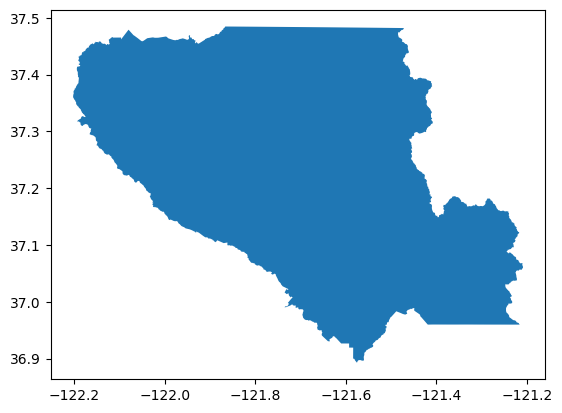

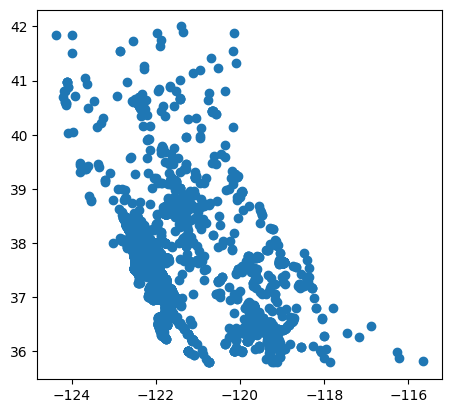

In [18]:
santa_clara_county_boundaries.plot()
transport_locations.plot()

### Santa clara data extraction

In [19]:
# take transport location within santa clara county boundaries
%time transport_location_is_in_santa_clara = transport_locations.apply(lambda x: gpd.GeoSeries(x.geometry, crs=4326).within(santa_clara_county_boundaries), axis=1)

CPU times: total: 37.1 s
Wall time: 1min 11s


In [20]:
transport_locations['transport_location_is_in_santa_clara'] = transport_location_is_in_santa_clara

In [21]:
transport_location_is_in_santa_clara.value_counts()

False    17601
True      3619
Name: count, dtype: int64

In [22]:
santa_clara_transport_locations = transport_locations.where(transport_locations.transport_location_is_in_santa_clara == True) \
.dropna() \
.drop(labels='transport_location_is_in_santa_clara', axis=1)

In [23]:
santa_clara_transport_locations

,osm_id,code,fclass,name,geometry
0,30236493,5601.0,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601.0,railway_station,Mountain View,POINT (-122.07588 37.39434)
16,266800225,5621.0,bus_stop,El Camino Real & East Remington Drive,POINT (-122.02439 37.36102)
18,266910711,5601.0,railway_station,Capitol,POINT (-121.84176 37.28397)
19,266944543,5601.0,railway_station,Morgan Hill,POINT (-121.65053 37.12970)
...,...,...,...,...,...
20503,9632354205,5621.0,bus_stop,Bus Stop #2,POINT (-121.92957 37.37230)
20504,9632354206,5621.0,bus_stop,Bus Stop #3,POINT (-121.92775 37.37190)
20505,9632354207,5621.0,bus_stop,Bus Stop #4,POINT (-121.92854 37.37317)
20506,9632354208,5621.0,bus_stop,Bus Stop #5,POINT (-121.92973 37.37373)


### Save santa clara data

In [43]:
santa_clara_transport_locations.to_file("data/County of Santa Clara/santa_clara_transport_free.geojson", driver='GeoJSON')

## Read santa clara data

In [6]:
santa_clara_transport_locations = gpd.read_file("data/County of Santa Clara/santa_clara_transport_free.geojson")

In [7]:
santa_clara_transport_locations.fclass.unique()

array(['railway_station', 'bus_stop', 'bus_station', 'helipad',
       'railway_halt', 'taxi'], dtype=object)

### Data exploration

In [8]:
santa_clara_transport_locations.drop(['osm_id',	'code'], axis=1).describe(include='all')

,fclass,name,geometry
count,3577,3577,3577
unique,6,2524,3549
top,bus_stop,San Jose Diridon Transit Center,POINT (-121.9526847 37.409416)
freq,3441,10,2


In [9]:
santa_clara_transport_locations.name.value_counts()

name
San Jose Diridon Transit Center         10
Santa Clara Transit Center              10
Milpitas Transit Center                  9
Showers Drive & Latham Street            8
Alum Rock Transit Center                 8
                                        ..
Harry Road & Grandwood Way               1
McKean Road & Martwood Way               1
McKean Road & Almaden Road               1
Almaden Road & Mountain Shadows Road     1
Bus Stop #6                              1
Name: count, Length: 2524, dtype: int64

In [10]:
santa_clara_transport_locations.fclass.value_counts()

fclass
bus_stop           3441
railway_station      77
bus_station          48
taxi                  6
helipad               3
railway_halt          2
Name: count, dtype: int64

### Data visualization

In [11]:
n = len(santa_clara_transport_locations.fclass.unique())
n

6

In [12]:
# get a colormap with n colors
cmap = ['green', 'gray', 'red', 'orange', 'olive', 'blue']#, 'pink', 'brown', 'gray', 'olive', 'cyan'']

# map colors to fclass
colors = {fclass: cmap[i] for i, fclass in enumerate(santa_clara_transport_locations.fclass.unique())}

# print colors
print(colors)

{'railway_station': 'green', 'bus_stop': 'gray', 'bus_station': 'red', 'helipad': 'orange', 'railway_halt': 'olive', 'taxi': 'blue'}


In [13]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [tuple([point[4].xy[1][0], point[4].xy[0][0], point[2]]) for point in santa_clara_transport_locations.values]

In [14]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations)):
    folium.Circle(geo_df_list[point][0:2], fill=True, color=colors[geo_df_list[point][2]]).add_to(map_)
map_

## P-center facility location solution

In [15]:
# Work on a sample of OPSM API data

demand_points = 50
n_locations_to_choose = 3
santa_clara_transport_locations_sample = santa_clara_transport_locations\
                                            .where(santa_clara_transport_locations.fclass == "bus_stop")\
                                            .dropna()\
                                            .sample(demand_points, random_state=1783297)

In [16]:
santa_clara_transport_locations_sample.fclass.value_counts()

fclass
bus_stop    50
Name: count, dtype: int64

<Axes: >

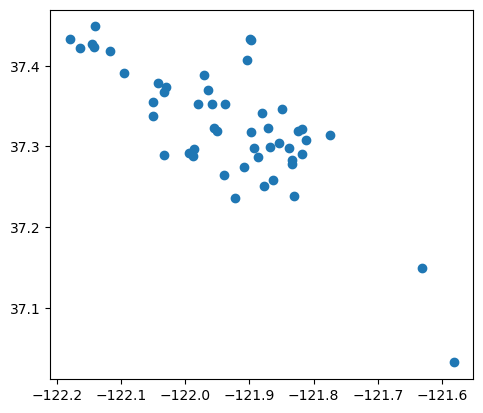

In [17]:
santa_clara_transport_locations_sample.plot()

In [18]:
# Create a geometry list from the GeoDataFrame
geo_df_list_sample = [[point.xy[0][0], point.xy[1][0]] for point in santa_clara_transport_locations_sample.geometry]

In [19]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations_sample)):
    folium.Circle([geo_df_list_sample[point][1],geo_df_list_sample[point][0]], fill=True, radius = 200).add_to(map_)
map_

### Compute the adjacency matrix

In [20]:
%%time
geometric_distance_matrix = AdjacencyMatrix(santa_clara_transport_locations_sample.geometry, kind="geometric")

CPU times: total: 93.8 ms
Wall time: 380 ms


C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 10N (the single non-null crs provided).
  warnings.warn(


In [21]:
%%time
osrm_distance_matrix = AdjacencyMatrix(santa_clara_transport_locations_sample.geometry, kind="osrm")

CPU times: total: 15.6 ms
Wall time: 416 ms


In [22]:
%%time
osrm_duration_matrix = AdjacencyMatrix(santa_clara_transport_locations_sample.geometry, kind="osrm", mode="duration")

CPU times: total: 15.6 ms
Wall time: 5.67 s


### Problem definition

In [42]:
fl_exact_geometric_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, geometric_distance_matrix)
fl_gon_geometric_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, geometric_distance_matrix)
fl_gon_plus_geometric_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, geometric_distance_matrix)

In [43]:
fl_exact_osrm_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_distance_matrix)
fl_gon_osrm_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_distance_matrix)
fl_gon_plus_osrm_distance = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_distance_matrix)

In [44]:
fl_exact_osrm_duration = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_duration_matrix)
fl_gon_osrm_duration = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_duration_matrix)
fl_gon_plus_osrm_duration = FacilityLocation(geo_df_list_sample, n_locations_to_choose, osrm_duration_matrix)

### Exact solution 

In [45]:
fl_exact_geometric_distance.solve(mode = "exact")
fl_exact_geometric_distance.save("data/County of Santa Clara/fl_exact_geometric_distance.pkl")

In [46]:
fl_exact_osrm_distance.solve(mode = "exact")
fl_exact_osrm_distance.save("data/County of Santa Clara/fl_exact_osrm_distance.pkl")

In [47]:
fl_exact_osrm_duration.solve(mode = "exact")
fl_exact_osrm_duration.save("data/County of Santa Clara/fl_exact_osrm_duration.pkl")

### Simple Gon

In [48]:
fl_gon_geometric_distance.solve(mode = "approx")
fl_gon_geometric_distance.save("data/County of Santa Clara/fl_gon_geometric_distance.pkl")

In [49]:
fl_gon_osrm_distance.solve(mode = "approx")
fl_gon_osrm_distance.save("data/County of Santa Clara/fl_gon_osrm_distance.pkl")

In [50]:
fl_gon_osrm_duration.solve(mode = "approx")
fl_gon_osrm_duration.save("data/County of Santa Clara/fl_gon_osrm_duration.pkl")

### Gon+

In [51]:
fl_gon_plus_geometric_distance.solve(mode = "approx", algorithm="gon_plus", n_trial=demand_points)
fl_gon_plus_geometric_distance.save("data/County of Santa Clara/fl_gon_plus_geometric_distance.pkl")

In [52]:
fl_gon_plus_osrm_distance.solve(mode = "approx", algorithm="gon_plus", n_trial=demand_points)
fl_gon_plus_osrm_distance.save("data/County of Santa Clara/fl_gon_plus_osrm_distance.pkl")

In [53]:
fl_gon_plus_osrm_duration.solve(mode = "approx", algorithm="gon_plus", n_trial=demand_points)
fl_gon_plus_osrm_duration.save("data/County of Santa Clara/fl_gon_plus_osrm_duration.pkl")

## Graphical Analysis

In [58]:
# read all .pkl files in the folder and store them in a list
folder_path = "data/County of Santa Clara/"
file_list = [file for file in os.listdir(folder_path) if file.endswith('.pkl')]
ls_list = [FacilityLocation.load(folder_path+e) for e in file_list]

In [61]:
graphical_report = FacilityLocationReport(ls_list)

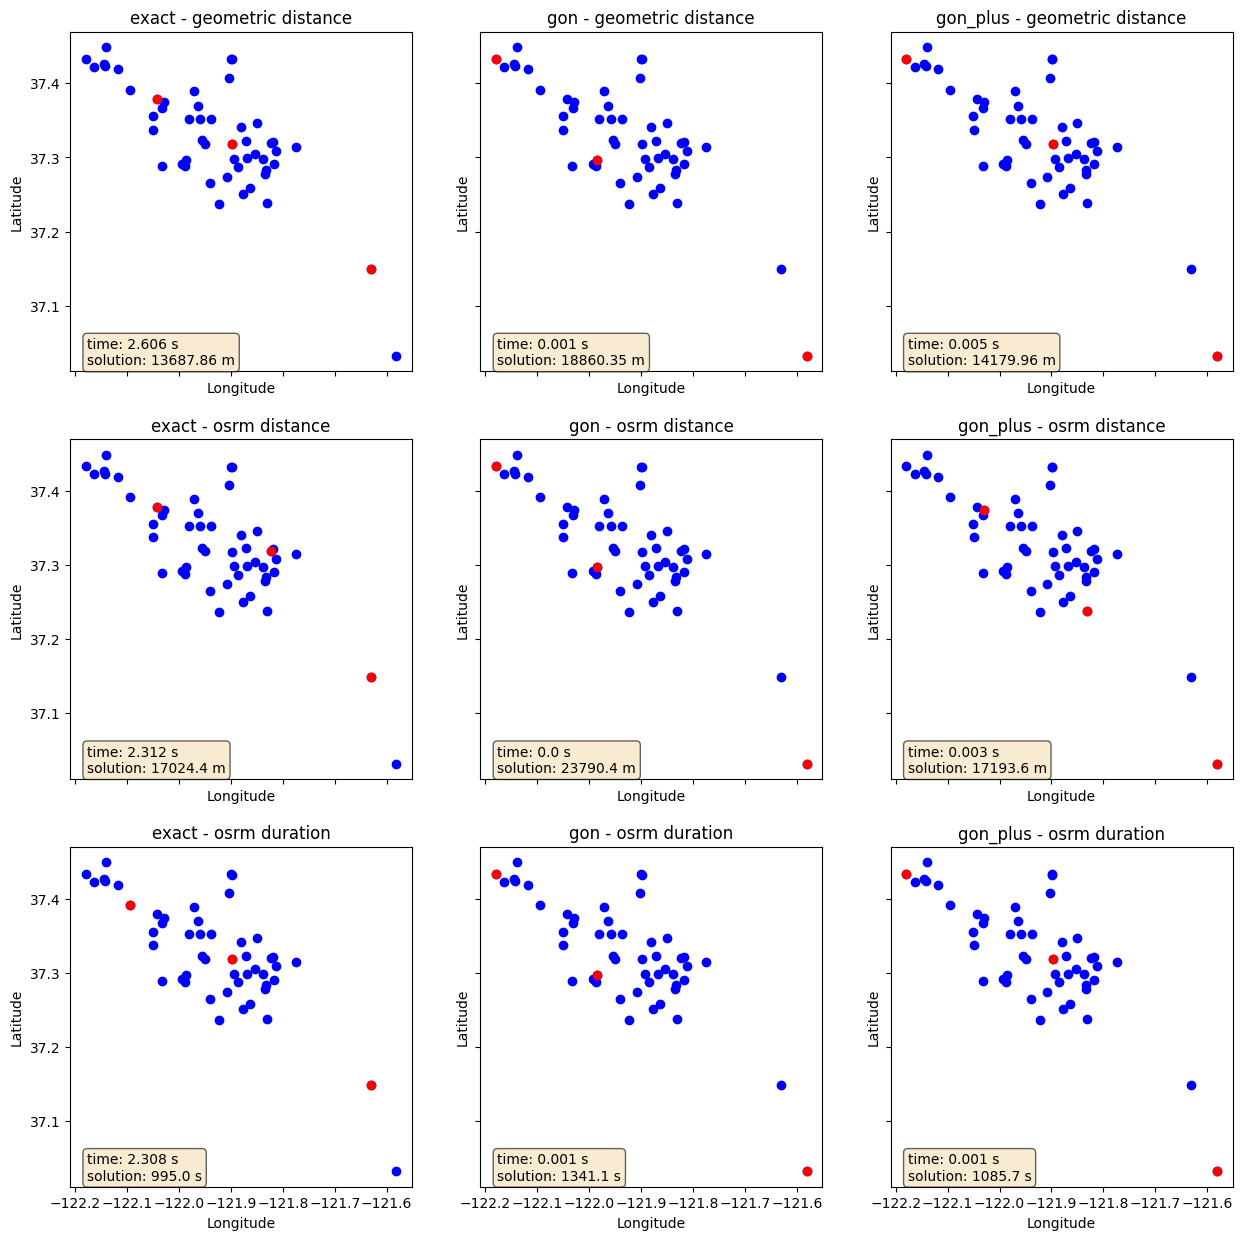

In [62]:
graphical_report.graphical_algorithm_solutions_comparison()

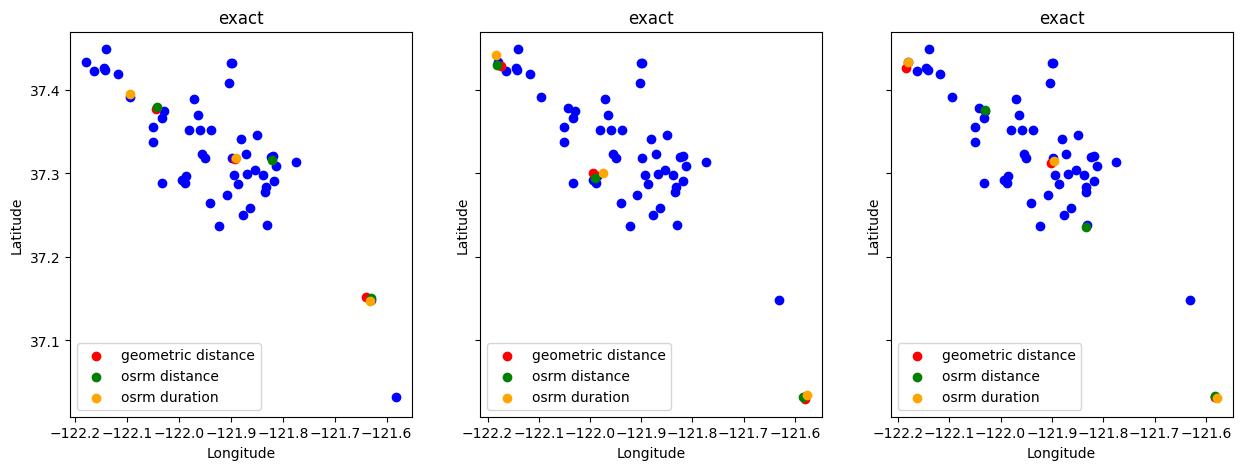

In [63]:
graphical_report.graphical_adjacency_marix_solutions_comparison()

# End